In [1]:
import os
import numpy as np
import threading as thr
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [19]:
mammo_o = []
mammo_f = []
label = []
project_folder = "C:/Users/anapascual/cmepda/progetto/dataset/"
os.chdir(project_folder)
l = os.listdir()

[WinError 123] El nombre de archivo, el nombre de directorio o la sintaxis de la etiqueta del volumen no son correctos: 'https:\\\\github.com\\bitgio\\CMEPDA_final_project\\tree\\main\\dataset'
C:\Users\anapascual\exam_project


In [6]:
def create_dataset(ls, o_img, f_img, lbl):
    for l in ls:
        if "_1_resized.pgm" in l:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(project_folder,l)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            lbl.append(1)
        elif "_2_resized.pgm" in l:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(project_folder,l)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            lbl.append(0)

In [7]:
os.chdir("C:/Users/anapascual/cmepda/progetto/")
threads = []
chunk = 49
for i in range(6):
    t = thr.Thread(target = create_dataset, args = (l[i*chunk : (i+1)*chunk], mammo_o, mammo_f, label))
    threads.append(t)
    t.start()

for i in threads:
    i.join()

In [8]:
eng.quit()

In [9]:
mammo_o = np.asarray(mammo_o, dtype = 'float32')/255.
mammo_f = np.asarray(mammo_f, dtype = 'float32')/255.
label = np.asarray(label)

In [10]:
mammo_o_4d = np.reshape(mammo_o, (147, 125, 125, 1))
print(mammo_o_4d.shape)
mammo_f_4d = np.reshape(mammo_f, (147, 64, 64, 1))
print(mammo_f_4d.shape)

(147, 125, 125, 1)
(147, 64, 64, 1)


In [11]:
def cnn_f(shape=(64, 64, 1)):
    model = Sequential([
        
        Conv2D(11, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
    
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.2),
        
        
        Conv2D(16, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(30, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((4,4), strides = 2),
        #Dropout(0.1),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [12]:
model_f = cnn_f()
model_f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 11)        110       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 11)       44        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 11)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 11)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 16)        1600      
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 16)       6

In [13]:
from tensorflow.keras.optimizers import SGD
learning_rate = 0.001
#model_o.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])
model_f.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

In [15]:
X_train_f, X_val_f, Y_train_f, Y_val_f = train_test_split(mammo_f_4d, label, test_size = 0.2)
batch_size = 49
traino = model_f.fit(X_train_f, Y_train_f,
                            batch_size = batch_size,
                            epochs = 200,
                            verbose=1,
                            validation_data=(X_val_f, Y_val_f),
                            callbacks=[reduce_on_plateau])
    

Epoch 1/200
3/3 [==============================] - 2s 322ms/step - loss: 0.8959 - accuracy: 0.4359 - val_loss: 0.7049 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/200
3/3 [==============================] - 0s 133ms/step - loss: 0.7894 - accuracy: 0.4530 - val_loss: 0.7010 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/200
3/3 [==============================] - 0s 84ms/step - loss: 0.6892 - accuracy: 0.5214 - val_loss: 0.6975 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 4/200
3/3 [==============================] - 0s 84ms/step - loss: 0.6265 - accuracy: 0.6752 - val_loss: 0.6918 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 5/200
3/3 [==============================] - 0s 81ms/step - loss: 0.5897 - accuracy: 0.7265 - val_loss: 0.6882 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 6/200
3/3 [==============================] - 0s 84ms/step - loss: 0.5630 - accuracy: 0.7265 - val_loss: 0.6903 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 7/200
3/3 [==============================] - 0s 84ms/step - loss: 0.5598 -

3/3 [==============================] - 0s 97ms/step - loss: 0.2454 - accuracy: 0.9060 - val_loss: 0.6261 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 55/200
3/3 [==============================] - 0s 103ms/step - loss: 0.2666 - accuracy: 0.8718 - val_loss: 0.6245 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 56/200
3/3 [==============================] - 0s 106ms/step - loss: 0.2415 - accuracy: 0.9231 - val_loss: 0.6257 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 57/200
3/3 [==============================] - 0s 105ms/step - loss: 0.2403 - accuracy: 0.9231 - val_loss: 0.6328 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 58/200
3/3 [==============================] - 0s 98ms/step - loss: 0.2384 - accuracy: 0.9145 - val_loss: 0.6389 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 59/200
3/3 [==============================] - 0s 111ms/step - loss: 0.2296 - accuracy: 0.9316 - val_loss: 0.6449 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 60/200
3/3 [==============================] - 0s 98ms/step - loss: 0.2273 - acc

3/3 [==============================] - 0s 92ms/step - loss: 0.1956 - accuracy: 0.9573 - val_loss: 0.7413 - val_accuracy: 0.6667 - lr: 1.0000e-08
Epoch 107/200
3/3 [==============================] - 0s 115ms/step - loss: 0.1914 - accuracy: 0.9658 - val_loss: 0.7426 - val_accuracy: 0.6667 - lr: 1.0000e-08
Epoch 108/200
3/3 [==============================] - 0s 100ms/step - loss: 0.1990 - accuracy: 0.9402 - val_loss: 0.7436 - val_accuracy: 0.6667 - lr: 1.0000e-08
Epoch 109/200
3/3 [==============================] - 0s 95ms/step - loss: 0.1932 - accuracy: 0.9487 - val_loss: 0.7446 - val_accuracy: 0.6667 - lr: 1.0000e-08
Epoch 110/200
3/3 [==============================] - 0s 94ms/step - loss: 0.1947 - accuracy: 0.9487 - val_loss: 0.7457 - val_accuracy: 0.6667 - lr: 1.0000e-08
Epoch 111/200
3/3 [==============================] - 0s 101ms/step - loss: 0.2061 - accuracy: 0.9658 - val_loss: 0.7464 - val_accuracy: 0.6667 - lr: 1.0000e-08
Epoch 112/200
3/3 [==============================] - 0s 1

3/3 [==============================] - 0s 101ms/step - loss: 0.1987 - accuracy: 0.9487 - val_loss: 0.6738 - val_accuracy: 0.7667 - lr: 1.0000e-13
Epoch 158/200
3/3 [==============================] - 0s 114ms/step - loss: 0.1977 - accuracy: 0.9402 - val_loss: 0.6717 - val_accuracy: 0.7667 - lr: 1.0000e-13
Epoch 159/200
3/3 [==============================] - 0s 95ms/step - loss: 0.1988 - accuracy: 0.9316 - val_loss: 0.6695 - val_accuracy: 0.7667 - lr: 1.0000e-13
Epoch 160/200
3/3 [==============================] - 0s 102ms/step - loss: 0.1888 - accuracy: 0.9573 - val_loss: 0.6679 - val_accuracy: 0.7667 - lr: 1.0000e-13
Epoch 161/200
3/3 [==============================] - 0s 97ms/step - loss: 0.1888 - accuracy: 0.9573 - val_loss: 0.6660 - val_accuracy: 0.7667 - lr: 1.0000e-13
Epoch 162/200
3/3 [==============================] - 0s 104ms/step - loss: 0.2042 - accuracy: 0.9487 - val_loss: 0.6643 - val_accuracy: 0.7667 - lr: 1.0000e-13
Epoch 163/200
3/3 [==============================] - 0s 

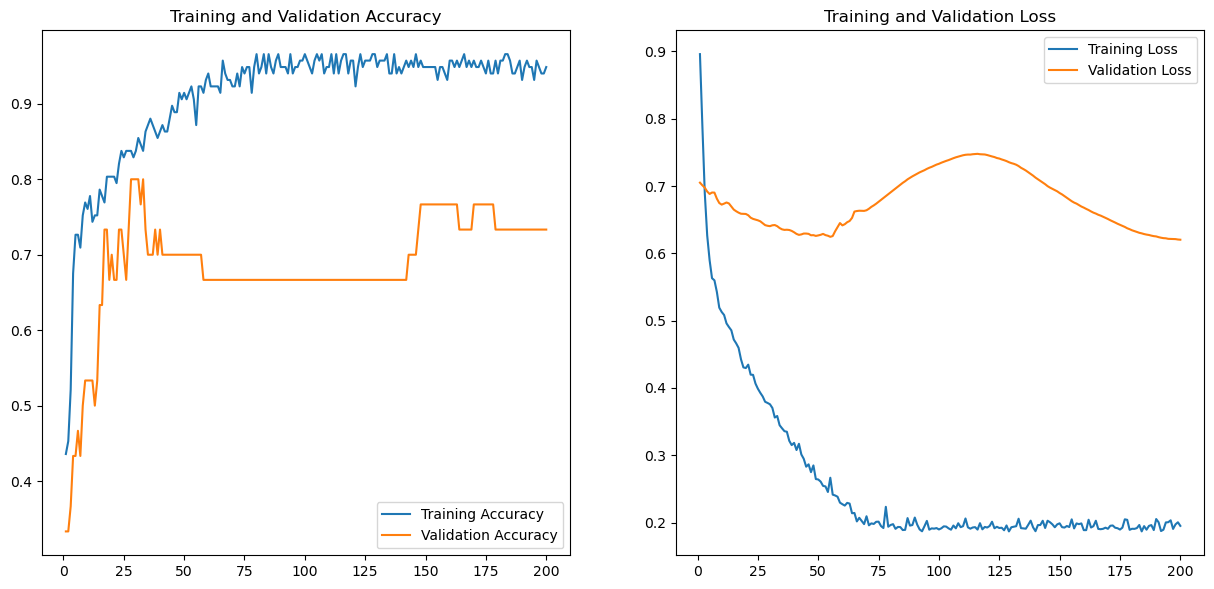

In [16]:
acc = traino.history['accuracy']
val_acc = traino.history['val_accuracy']
loss = traino.history['loss']
val_loss = traino.history['val_loss']
    
epochs_range = range(1, len(acc)+1)
    #Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
    #Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Validation accuracy: 0.733
1/1 [==============================] - 0s 225ms/step


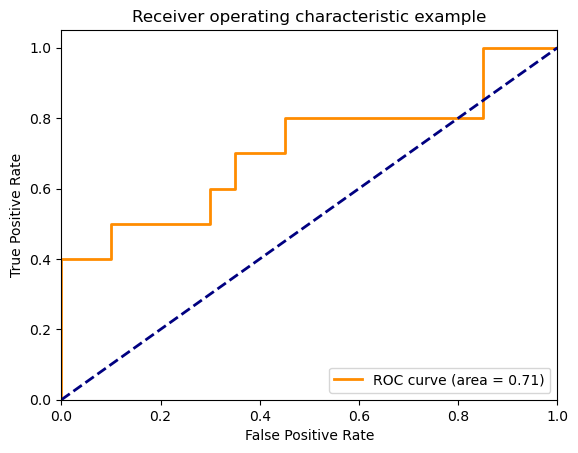

In [17]:
_, val_acc = model_f.evaluate(X_val_f, Y_val_f, verbose=0)
print('Validation accuracy: %.3f' % (val_acc))
    
    
preds = model_f.predict(X_val_f, verbose=1)

    #Compute Receiver operating characteristic (ROC)
fpr, tpr, _ = roc_curve(Y_val_f, preds)

roc_auc = auc(fpr, tpr)
   #Plot of a ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#CROSS-VALIDATION with ORIGINAL DATA (X_slice_o)

A = []
V_A = []
L = []
V_L = []
ROC = []

for i in range(3):
    X_train_o, X_val_o, Y_train_o, Y_val_o = train_test_split(mammo_o_4d, label, test_size = 0.168, random_state = 40)
    traino = model_o.fit(X_train_o, Y_train_o,
                            batch_size = 49,
                            epochs = 200,
                            verbose=1,
                            validation_data=(X_val_o, Y_val_o),
                            callbacks=[checkpoint,reduce_on_plateau])
    
    acc = traino.history['accuracy']
    val_acc = traino.history['val_accuracy']
    loss = traino.history['loss']
    val_loss = traino.history['val_loss']
    
    A.append(acc)
    V_A.append(val_acc)
    L.append(loss)
    V_L.append(val_loss)
    
    epochs_range = range(1, len(acc)+1)
    #Train and validation accuracy 
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    #Train and validation loss 
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
    _, val_acc = model_o.evaluate(X_val_o, Y_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    
    
    preds = model_o.predict(X_val_o, verbose=1)

    #Compute Receiver operating characteristic (ROC)
    fpr, tpr, _ = roc_curve(Y_val_o, preds)

    roc_auc = auc(fpr, tpr)
    ROC.append(roc_auc)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
media = np.mean(ROC)
std = np.std(ROC)
print(media)
print(std)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
                rotation_range = 90,
                horizontal_flip = True,
                vertical_flip = True,
                validation_split = 0.21)

Xaug_train_o = aug.flow(X_slice_o, Y_slice_o, batch_size = 30, subset = 'training')
Xaug_val_o = aug.flow(X_slice_o, Y_slice_o, batch_size = 30, subset = 'validation')

Xaug_train_f = aug.flow(X_slice_f, Y_slice_f, subset = 'training')
Xaug_val_f = aug.flow(X_slice_f, Y_slice_f, subset = 'validation')